In [1]:
import sys
sys.path.append("/home/imglab/Yi_Zhu/Smart_Project_v10/")
import os
from digital_network import *
from digital_unit import *
from optical_network import *
from optical_unit import *
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from new_shapes_dataset import TwoPaddedRotationShapesDataset
import matplotlib.pyplot as plt
import pickle
from model_retrieve_utils import *
from utils import *
import math

/home/imglab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparameters for training
lr = 0.05
max_epochs = 20
batch_epochs = 3000

# optical parameter
system_dim = 200
canvas_dim = system_dim // 4
# canvas_dim = 50
phase_dim = 200
pixel_size = 9.2e-6
focal_length = 20e-3    #  200e-3  # 14.5e-2
wave_lambda = 795e-9

# hyperparameters for digital cnn layer used to retrieve kernels
in_c = 1
out_c = 4      # kernels 
fc_in = out_c
rows = 2
cols = 2


In [3]:
# saving configurations
server_dir = "/home/imglab/Yi_Zhu/Smart_Project_v10/"
sub_dir = "results/"
dateinfo = "Mar_04_2024_20_57_28/"

model_folder = server_dir + sub_dir + dateinfo +'saved_onn_models/'
curve_folder = server_dir + sub_dir + dateinfo +'saved_training_curves/'

model_file_name = "complex_valued_optical_net_4kernel_ep20_lrp00005_focal20mm.pt"
curve_file_name = "complex_valued_optical_net_4kernel_ep20_lrp00005_focal20mm.pickle"

MODEL_PATH = model_folder + model_file_name
CURVE_PATH = curve_folder + curve_file_name

In [4]:
model = FourierConvComplex(system_dim, phase_dim, pixel_size, focal_length, wave_lambda)
model.load_state_dict(torch.load(f=MODEL_PATH))

<All keys matched successfully>

In [5]:
wp = model.phase.w_p
mask_phase = torch.sigmoid(wp) * 1.999 * math.pi
mask_complex = torch.complex(torch.cos(mask_phase), torch.sin(mask_phase))

In [6]:
mask_complex.shape

torch.Size([1, 200, 200])

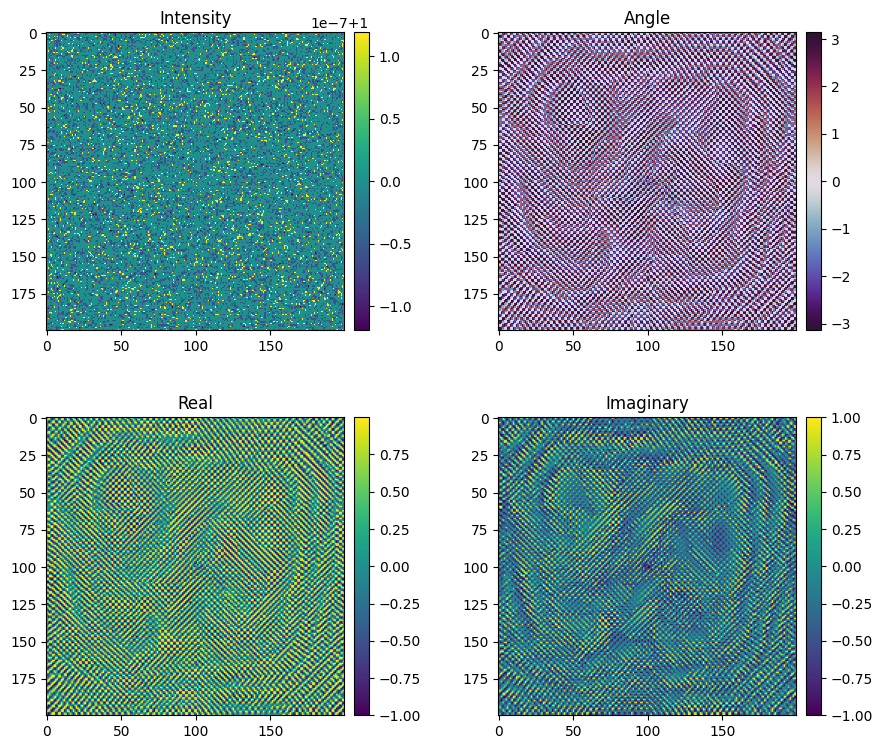

In [7]:
plot_complex_image(mask_complex[0].detach().numpy())

In [8]:
wp

Parameter containing:
tensor([[[ 0.2085, -0.5240,  2.8262,  ...,  2.7828,  2.4863,  0.8989],
         [ 0.9817,  2.6316,  3.4075,  ...,  3.1275, -0.4917,  0.1269],
         [ 1.9125,  2.0862,  1.7533,  ...,  1.3012, -0.3725, -0.3349],
         ...,
         [ 2.3244,  2.6045,  1.7573,  ...,  1.3906, -0.1521, -0.1249],
         [ 3.0835,  0.0040,  0.3864,  ...,  0.3489,  1.4742,  3.1269],
         [-0.7611, -0.1678,  0.4873,  ...,  0.3135,  2.3892,  3.0184]]],
       requires_grad=True)

In [9]:
# plot_complex_image(torch.fft.fftshift(torch.fft.fft2(mask_complex[0])).detach().numpy())

### image pass through model

In [10]:
dimension = 200

# hyperparameters for training and testing set
num_training_set = 50000
num_testing_set = 10000
shape_size = 0
canvas_color = 0
fill = 10


# define dataset and data loader
train_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_training_set, canvas_color=canvas_color, fill=fill)
train_loader = DataLoader(train_dataset, batch_size=20, num_workers=6, shuffle=False)

test_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_testing_set, canvas_color=canvas_color, fill=fill)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=6, shuffle=False)

In [11]:
X_train_dummy, y_train_dummy = create_dummy_sample(train_loader, 10)
X_train_dummy.shape, y_train_dummy.shape

(torch.Size([10, 200, 200]), torch.Size([10, 2]))

In [12]:

# define loss fn and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


X_ = X_train_dummy[0].to(device)

output_field = model(X_)

In [13]:
output_field.shape

torch.Size([1, 200, 200])

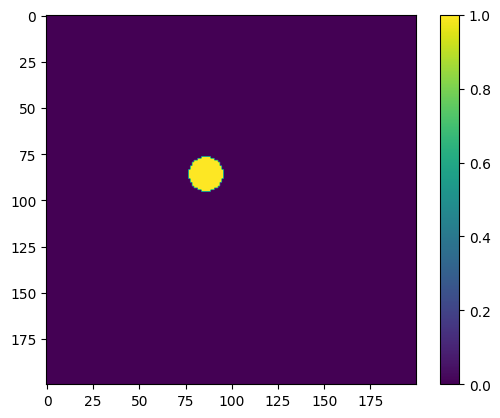

In [14]:
plt.imshow(X_train_dummy[0])
plt.colorbar()

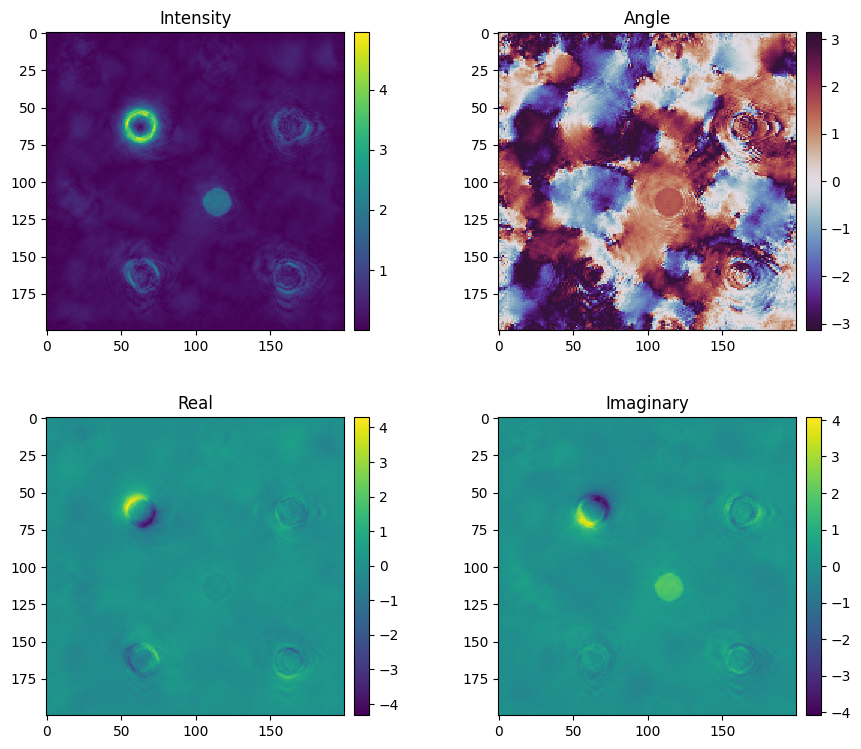

In [15]:
plot_complex_image(output_field[0].cpu().detach().numpy())

In [16]:
# define the impulse function
def impulse_function(dimension):
    image = np.zeros((1, dimension, dimension))
    image[0, dimension//2, dimension//2] = 1
    image = torch.tensor(image, dtype=torch.complex64)
    return image

In [17]:
impulse = impulse_function(200).to(device)
impulse.shape, impulse.device

(torch.Size([1, 200, 200]), device(type='cuda', index=0))

In [18]:
# pass impulse image through the network
output_field_impulse = model(impulse)

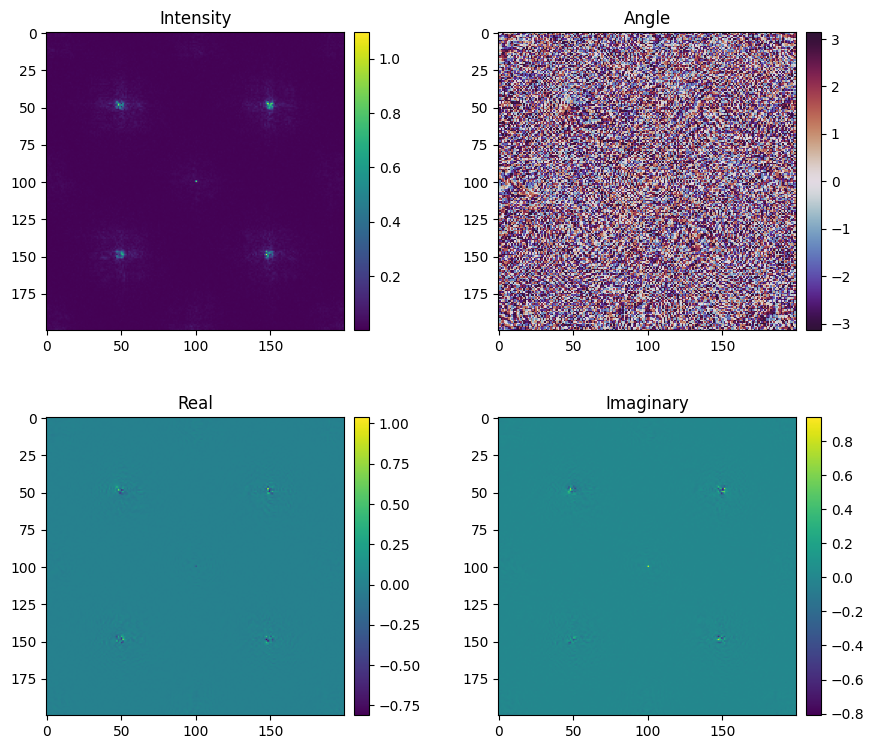

In [19]:
plot_complex_image(output_field_impulse[0].cpu().detach().numpy())

In [20]:
reconstruct_kernels = split_kernels(output_field_impulse[0], cols, rows)

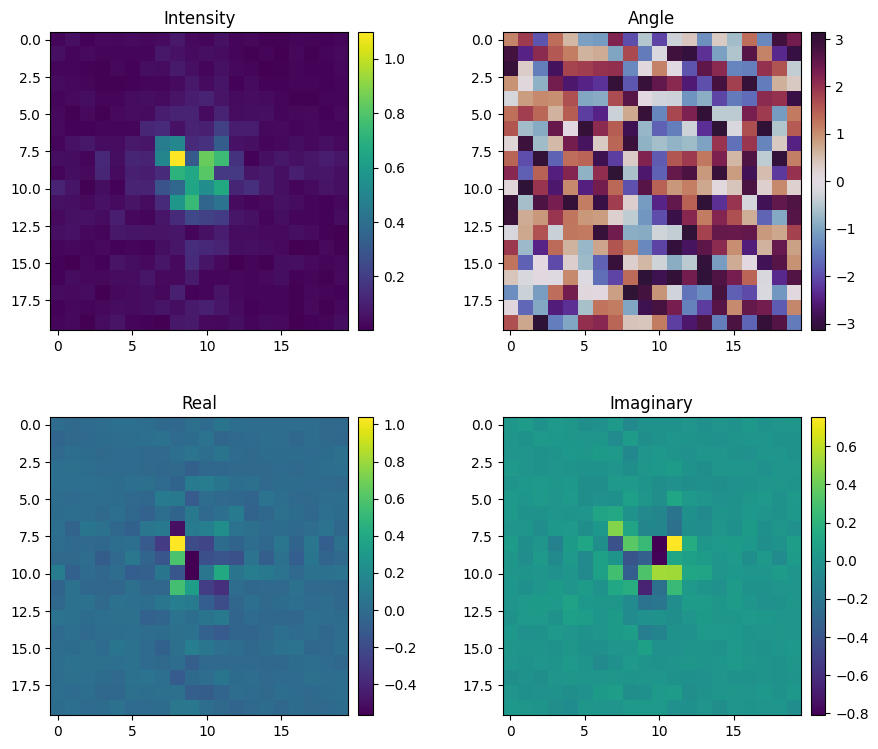

In [21]:
plot_complex_image(reconstruct_kernels[1][40:60,40:60].cpu().detach().numpy())

In [22]:
# reconstruct_kernels[0][0]